In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
np.random.seed(20201229)
tf.set_random_seed(20201229)

In [5]:
# --- ORENISTデータセットを読み込む ---
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file, encoding='latin1')
print(images[0])
print(labels[0])
print(type(images[0]))
print(type(labels))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00392157 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01176471 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [3]:
# --- フィルターを適用する ---
def edge_filter():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2]) # フィルターサイズ（縦横）×入力レイヤー数 (RGBなら3)×出力レイヤー数 (フィルターの数)
    filter_array[:,:,0,0] = filter0 # 実験的に今回はフィルターを指定
    filter_array[:,:,0,1] = filter1 # 実験的に今回はフィルターを指定

    return tf.constant(filter_array, dtype=tf.float32)

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1]) # 画像の枚数×画像サイズ（縦×横）×レイヤー数の多次元リストでデータを与える, -1はデータ数に応じて調整するという意味

W_conv = edge_filter()
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv, strides=[1,1,1,1], padding='SAME'))# 入力x_imageに対してフィルターW_convをかける, [1, dy, dx, 1]でdy, dxは縦横方向のピクセルの抽出数, SAMEはゼロパディング
h_conv_cutoff = tf.nn.relu(h_conv-0.2) # 0.2を引いてReluに代入することで，畳み込みフィルターで0.2以下になったところは強制的に0にする

h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [4]:
# --- ニューラルネットワークの設計 ---
h_pool_flat = tf.reshape(h_pool, [-1, 392])

num_units1 = 392
num_units2 = 2

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 3])) # 3種類に分類
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

In [5]:
# --- 損失関数を定義 ---
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# --- パラメータを最適化 ---
sess = tf.Session()
sess.run(tf.initialize_all_variables())
i = 0
for _ in range(200):
    i += 1
    sess.run(train_step, feed_dict={x:images, t:labels})
    if i % 10 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:images, t:labels})
        print ('Step: %d, Loss: %f, Accuracy: %f' % (i, loss_val, acc_val))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step: 10, Loss: 98.377541, Accuracy: 0.533333
Step: 20, Loss: 97.726471, Accuracy: 0.566667
Step: 30, Loss: 96.938766, Accuracy: 0.588889
Step: 40, Loss: 96.033913, Accuracy: 0.600000
Step: 50, Loss: 94.938438, Accuracy: 0.644444
Step: 60, Loss: 93.446884, Accuracy: 0.711111
Step: 70, Loss: 91.337967, Accuracy: 0.811111
Step: 80, Loss: 88.487411, Accuracy: 0.877778
Step: 90, Loss: 85.240135, Accuracy: 0.944444
Step: 100, Loss: 82.290199, Accuracy: 0.966667
Step: 110, Loss: 79.827156, Accuracy: 0.977778
Step: 120, Loss: 77.687019, Accuracy: 0.977778
Step: 130, Loss: 75.750938, Accuracy: 0.988889
Step: 140, Loss: 73.970062, Accuracy: 0.988889
Step: 150, Loss: 72.313667, Accuracy: 0.988889
Step: 160, Loss: 70.757729, Accuracy: 0.988889
Step: 170, Loss: 69.284019, Accuracy: 0.988889
Step: 180, Loss: 67.879082, Accuracy: 0.988889
Step: 190, Loss: 66.532463, Accuracy: 0.988889
Step: 200, Loss: 65.234879, Accuracy: 0.98

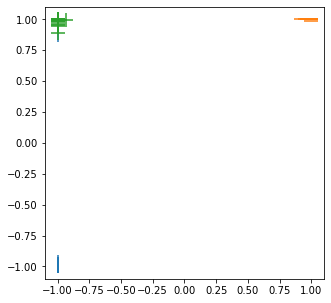

In [7]:
hidden2_vals = sess.run(hidden2, feed_dict={x:images})

z1_vals = [[],[],[]]
z2_vals = [[],[],[]]

for hidden2_val, label in zip(hidden2_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden2_val[0])
    z2_vals[label_num].append(hidden2_val[1])
    
fig = plt.figure(figsize=(5,5))
subplot = fig.add_subplot(1,1,1)
subplot.scatter(z1_vals[0], z2_vals[0], s=200, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=200, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=200, marker='+')